In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity
from deepinv.models.complex import to_complex_denoiser

In [3]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 2 with 32497 MB free memory 


In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 32
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 32, 32])

In [5]:
x.mean(), x.min(), x.max()

(tensor(0.1231, device='cuda:2'),
 tensor(0., device='cuda:2'),
 tensor(0.7412, device='cuda:2'))

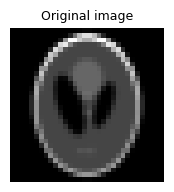

In [6]:
plot(x, titles="Original image")

In [7]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [8]:
oversampling_ratio = 5.0
img_shape = x.shape[1:]
m = int(oversampling_ratio * torch.prod(torch.tensor(img_shape)))

noise_level_img = 0.05  # Gaussian Noise standard deviation for the degradation
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.RandomPhaseRetrieval(
    m=m,
    img_shape=img_shape,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
    device=device,
)
y = physics(x_phase)

initial loss: tensor([224.4312], device='cuda:2')
final loss: tensor([70.6016], device='cuda:2')


TypeError: can't convert cuda:2 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

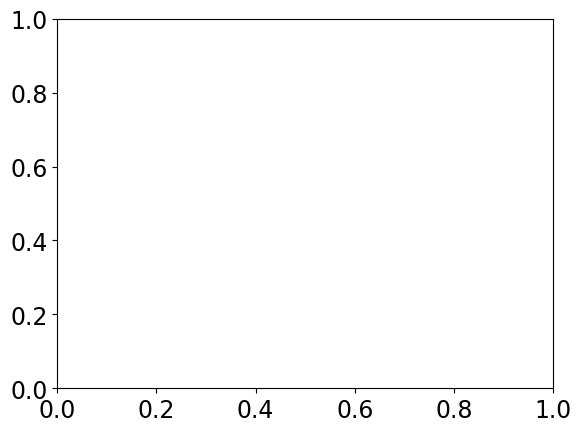

In [9]:
data_fidelity = L2()
# Step size for the gradient descent
stepsize = 5e-3
num_iter = 1000

# Initial guess
x_phase_gd_rand = torch.randn_like(x_phase)

loss_hist = []

for _ in range(num_iter):
    x_phase_gd_rand = x_phase_gd_rand - stepsize * data_fidelity.grad(x_phase_gd_rand, y, physics)
    loss_hist.append(data_fidelity(x_phase_gd_rand, y, physics))

print("initial loss:", loss_hist[0])
print("final loss:", loss_hist[-1])
# Plot the loss curve
plt.plot(loss_hist)
plt.yscale("log")
plt.title("loss curve (gradient descent with random initialization)")
plt.show()

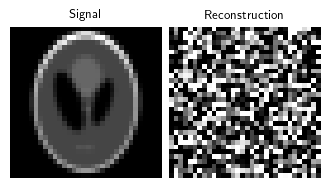

In [10]:
# correct possible global phase shifts
x_gd_rand = correct_global_phase(x_phase_gd_rand, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_rand = torch.angle(x_gd_rand) / torch.pi + 0.5

plot([x, x_gd_rand],titles=["Signal","Reconstruction"],rescale_mode='clip')

In [11]:
x_phase_spec = physics.A_dagger(y, n_iter=300)
x_phase_spec = x_phase_spec * torch.sqrt(y.sum())
print(cosine_similarity(x_phase_spec, x_phase))
x_phase_spec.shape

tensor(0.8835)


torch.Size([1, 1, 32, 32])

In [21]:
y_multi = torch.concat([y, y, y], dim=0)
x_phase_spec_multi = physics.A_dagger(y_multi, n_iter=300)
x_phase_spec_multi.shape

torch.Size([3, 1, 32, 32])

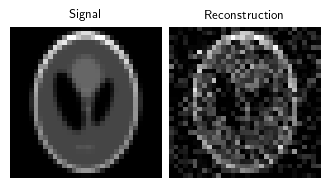

In [24]:
x_multi = torch.concat([x_phase, x_phase, x_phase], dim=0)
x_phase_spec_multi = correct_global_phase(x_phase_spec_multi, x_multi)
# extract phase information and normalize to the range [0, 1]
x_spec_multi = torch.angle(x_phase_spec_multi) / torch.pi + 0.5
plot([x, x_spec_multi[2]],titles=["Signal","Reconstruction"],rescale_mode='clip')

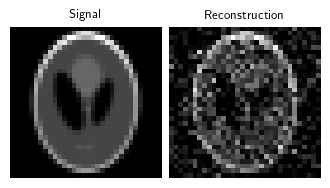

In [12]:
# correct possible global phase shifts
x_spec = correct_global_phase(x_phase_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_spec = torch.angle(x_spec) / torch.pi + 0.5
plot([x, x_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

loss_init: tensor([92.2681])
loss_final: tensor([0.0024])


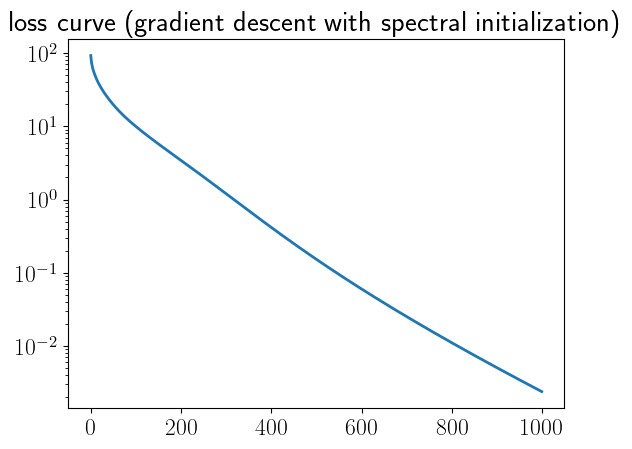

In [13]:
# spectral methods
x_phase_gd_spec = physics.A_dagger(y,n_iter=100)
x_phase_gd_spec = x_phase_gd_spec * torch.sqrt(y.sum())
loss_hist = []
for _ in range(num_iter):
    x_phase_gd_spec = x_phase_gd_spec - stepsize * data_fidelity.grad(x_phase_gd_spec, y, physics)
    loss_hist.append(data_fidelity(x_phase_gd_spec, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.yscale('log')
plt.title('loss curve (gradient descent with spectral initialization)')
plt.show()

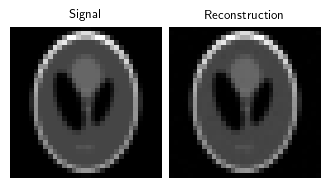

In [14]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

In [10]:
denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
)
denoiser_complex = to_complex_denoiser(denoiser,mode="abs_angle")

In [11]:
# Select the data fidelity term
data_fidelity = L2()

prior = PnP(denoiser=denoiser_complex)

params_algo = {"stepsize": 5e-4, "g_param": 0.04}
max_iter = 3000
early_stop = True

# Logging parameters
verbose = True

# instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

In [12]:
# run the model on the problem.
x_phase_pnp, metrics = model(
    y, physics, x_gt=x_phase, compute_metrics=True
)  # reconstruction with PnP algorithm

0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04
0.04


Image 0, channel 0 does not have a global phase shift.


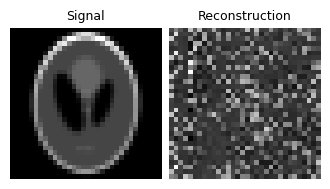

In [44]:
# correct possible global phase shifts
x_pnp = correct_global_phase(x_phase_pnp, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_pnp = torch.angle(x_pnp) / (2*torch.pi) + 0.5
plot([x, x_pnp],titles=["Signal","Reconstruction"],rescale_mode='clip')

In [45]:
x_pnp

tensor([[[[0.3088, 0.4844, 0.3295,  ..., 0.4033, 0.2958, 0.2469],
          [0.2464, 0.8068, 0.2578,  ..., 0.5145, 0.2227, 0.2337],
          [0.7374, 0.2499, 0.2453,  ..., 0.6216, 0.4468, 0.2668],
          ...,
          [0.2550, 0.8985, 0.2698,  ..., 0.2580, 0.1450, 0.3961],
          [0.6732, 0.2776, 0.2706,  ..., 0.5284, 0.1870, 0.4659],
          [0.4843, 0.4391, 0.2283,  ..., 0.2067, 0.6210, 0.3261]]]],
       device='cuda:2')

In [46]:
# plot images. Images are saved in RESULTS_DIR.
imgs = [x, x_gd_rand, x_spec, x_gd_spec, x_pnp]
plot(
    imgs,
    titles=["Original", "GD random", "Spectral", "GD spectral", "PnP (random init)"],
    save_dir=RESULTS_DIR / "images",
    show=True,
    rescale_mode="clip",
)

print(f"GD Random reconstruction, PSNR: {dinv.utils.metric.cal_psnr(x, x_gd_rand):.2f} dB; cosine similarity: {cosine_similarity(x_phase_gd_rand, x_phase):.3f}.")
print(f"Spectral reconstruction, PSNR: {dinv.utils.metric.cal_psnr(x, x_spec):.2f} dB; cosine similarity: {cosine_similarity(x_phase_spec, x_phase):.3f}.")
print(f"GD Spectral reconstruction, PSNR: {dinv.utils.metric.cal_psnr(x, x_gd_spec):.2f} dB; cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.3f}.")
print(f"PnP reconstruction, PSNR: {dinv.utils.metric.cal_psnr(x, x_pnp):.2f} dB; cosine similarity: {cosine_similarity(x_phase_pnp, x_phase):.3f}.")

NameError: name 'x_gd_rand' is not defined